In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm



import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


Extracting the files from the zip file.

In [4]:
from io import BytesIO
from zipfile import ZipFile
zipfile = ZipFile('/content/archive.zip')
zipfile.extractall(path = './brainMriImages')

Initially, we displayed a few images to see the shape of images in our dataset.  

(201, 173, 3)


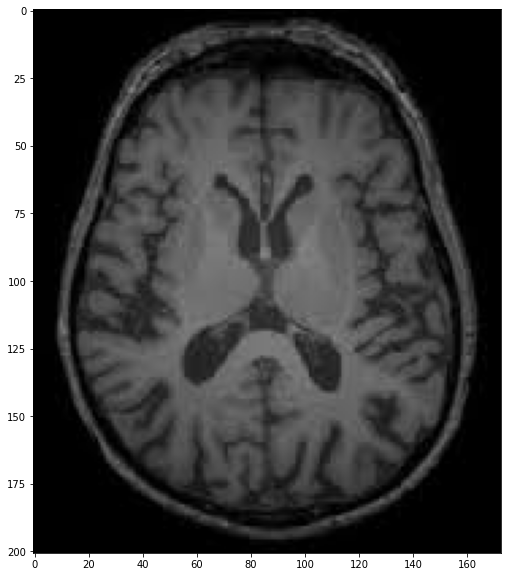

In [5]:
plt.figure(figsize=(16,10))
import matplotlib.image as mpimg

img=imread('/content/brainMriImages/brain_tumor_dataset/no/10 no.jpg')[:,:]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

The above image had 3 channels but the below image did'nt have any channels.

(630, 630)


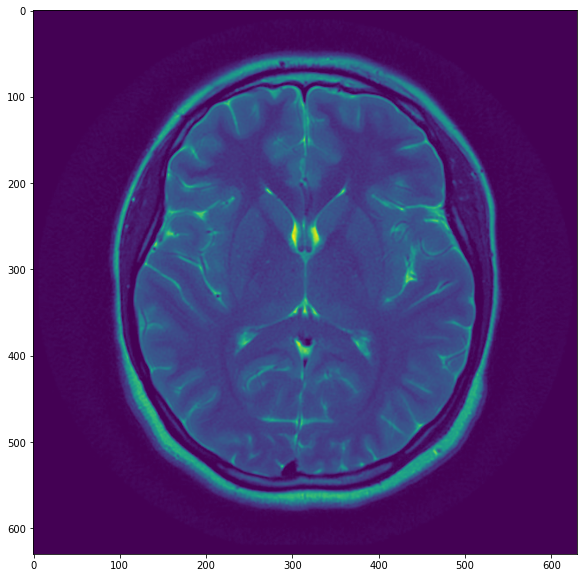

In [6]:
plt.figure(figsize=(16,10))
img=imread('/content/brainMriImages/brain_tumor_dataset/no/1 no.jpeg')[:,:]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

(218, 180)


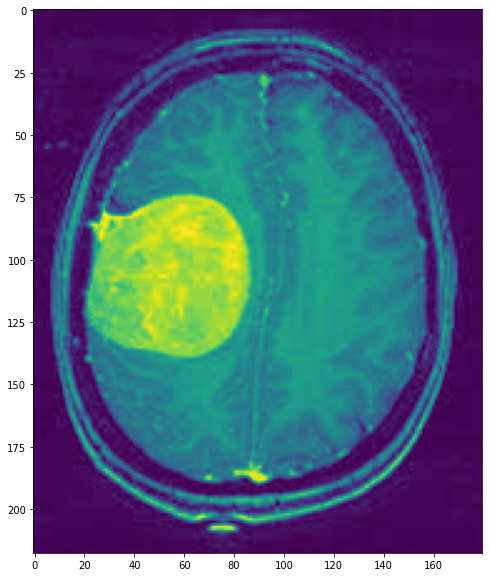

In [7]:
plt.figure(figsize=(16,10))
img=imread('/content/brainMriImages/brain_tumor_dataset/yes/Y1.jpg')[:,:,0]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

(360, 319)


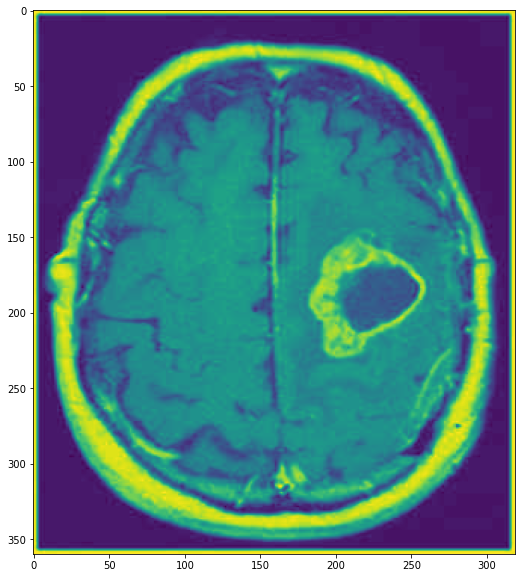

In [8]:
plt.figure(figsize=(16,10))
img=imread('/content/brainMriImages/brain_tumor_dataset/yes/Y10.jpg')[:,:]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

To extract all images in the file path 'no', we used the glob function.

In [19]:
images= glob('/content/brainMriImages/brain_tumor_dataset/no/*')

In [20]:
len(images)

98

To extract all images in the file path 'yes', we used the glob function. We combined both the yes and no images together.

In [21]:
images=images+glob('/content/brainMriImages/brain_tumor_dataset/yes/*')

In [22]:
len(images)

253

We shuffled the images for randomness.

In [13]:
from random import shuffle 
shuffle(images)



In [14]:
images

['/content/brainMriImages/brain_tumor_dataset/yes/Y35.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y55.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y108.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y53.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y112.JPG',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y58.JPG',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y31.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y99.JPG',
 '/content/brainMriImages/brain_tumor_dataset/no/N3.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/37 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y188.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/21 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y56.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y61.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 8.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y107.jpg',
 '/content/brainMriImages/brain_tumo

We checked the shape of every image and found every image do be of differnet size and shape. There are cases where an image had 3 channels, 4 channels and no channels. There were even cases where channels existed at a different position. For modeling we need to make sure that every image is same size

In [15]:
for i in images:
  print(imread(i).shape)

(446, 450, 3)
(620, 620, 3)
(1200, 1059, 3)
(219, 230, 3)
(366, 310, 3)
(340, 314, 3)
(294, 250)
(357, 283, 3)
(275, 220)
(225, 225, 3)
(879, 766, 3)
(225, 225, 3)
(239, 211, 3)
(520, 433, 3)
(361, 642, 3)
(512, 512, 3)
(236, 214, 3)
(278, 236)
(243, 207, 3)
(168, 300, 3)
(338, 264, 3)
(234, 216, 3)
(225, 225, 3)
(360, 313, 3)
(198, 150, 3)
(200, 200, 3)
(300, 240)
(456, 374, 3)
(360, 319)
(238, 212, 3)
(355, 311, 3)
(354, 303, 3)
(586, 467, 3)
(218, 180, 3)
(225, 225, 3)
(342, 273, 3)
(351, 262, 3)
(540, 504, 3)
(244, 206, 3)
(280, 420, 3)
(1024, 1024)
(338, 283, 3)
(248, 208, 3)
(225, 225, 3)
(380, 310, 3)
(324, 278, 3)
(449, 359, 3)
(630, 630)
(225, 225, 3)
(300, 240, 3)
(315, 289, 3)
(251, 201, 3)
(555, 526, 3)
(173, 189, 3)
(231, 218, 3)
(256, 197, 3)
(630, 504, 3)
(225, 225, 3)
(993, 825, 3)
(250, 201, 3)
(225, 225, 3)
(221, 228, 3)
(350, 272, 3)
(442, 353, 3)
(217, 232, 3)
(237, 213, 3)
(323, 276, 3)
(338, 248, 3)
(512, 512, 3)
(298, 260, 3)
(251, 204, 3)
(349, 292, 3)
(251, 201

Extracting images which had 4 channels at the first position in shape.

In [16]:
for i in images:
  if(imread(i).shape[0]==4):
    print(i)

/content/brainMriImages/brain_tumor_dataset/no/no 96.jpg
/content/brainMriImages/brain_tumor_dataset/no/No18.jpg
/content/brainMriImages/brain_tumor_dataset/no/no.jpg
/content/brainMriImages/brain_tumor_dataset/no/No17.jpg
/content/brainMriImages/brain_tumor_dataset/no/No15.jpg


torch.Size([4, 400, 393])
torch.Size([1, 4, 512, 512])


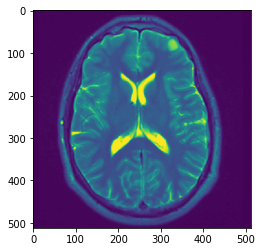

In [17]:
img=imread('/content/brainMriImages/brain_tumor_dataset/no/No17.jpg')

img=img/255.0           # to convert RGB images which are in range [0,255] to [0.0,1.0]
img=torch.tensor(img)   # converting numpy array into tensor object
print(img.shape)
img=img.unsqueeze(0)    # adding a new dimension by filling with zero's
img = F.interpolate(img, (512, 512))  # Down/up samples the input to either the given size or the given scale_factor 
print(img.shape)
imgplot = plt.imshow(img[0,0,:,:]) # displaying the image using imshow() function
plt.show()


In [18]:
img.shape

torch.Size([1, 4, 512, 512])